# Real or Not? NLP with Disaster Tweets

<img src="https://storage.googleapis.com/kaggle-media/competitions/nlp1-cover.jpg">





### Author: Arthur Dimitri <br>
### arthur.dimitri@ee.ufcg.edu.br

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/glove-data/glove.6B.200d.txt


# Introduction

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster, it could be metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine. The challenge here is to develop a machine learning model to predict wether a tweet is related to a disaster or not.

# Dataset Description

### Features

1. id - a unique identifier for each tweet
2. text - the text of the tweet
3. location - the location the tweet was sent from (may be blank)
4. keyword - a particular keyword from the tweet (may be blank)
5. target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

### Files
1. train.csv - the training set
2. test.csv - the test set
3. sample_submission.csv - a sample submission file in the correct format

# Dependencies

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
import operator
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import re
import nltk
import pandas as pd
from collections import Counter
from itertools import chain
import tensorflow as tf
from keras.optimizers import Nadam
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, classification_report


Using TensorFlow backend.


# Loading Data

In [3]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Exploratory Data Analysis

#### Initial Hypothesis (What makes a disaster tweet?)
1. Do hashtags and at count correlate with the target variable?
2. Are there some keywords that are common on disasters?
3. Do the number of characters on sentences help to identify a disaster? What about the number of words?
4. Do punctuation correlate to the target? 


Note that some data cleaning will be done while the exploration is made. Some might help subsequent analysis and some, if done previously, could harm specific analysis. 

### Null Features
Which features have most missing values?**

In [5]:
def getNullColDict(train,columns):
    null_count = []
    for column in columns:
        null_count.append((train[column].isnull().sum())*100/(train.shape[0]))
    
    dict_percentage = dict(zip(columns,null_count))
    return dict_percentage

columns = list(train.columns[1:])
dict_percentage = getNullColDict(train,columns)   
dict_percentage = dict(sorted(dict_percentage.items(), key=lambda x: x[1]))

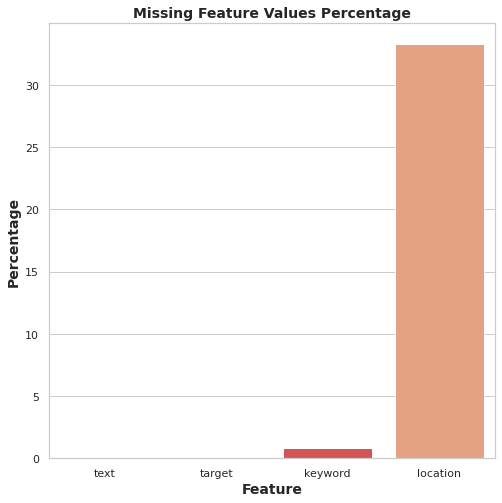

In [6]:
def barplot(X,Xlabel,Y,Ylabel,title,size=(10,10)):
    plt.figure(figsize=size)
    sns.set(style="whitegrid")
    plt.title(title,fontsize=14,fontweight="bold")
    plt.xlabel(Xlabel,fontsize=14,fontweight="bold")
    plt.ylabel(Ylabel,fontsize=14,fontweight="bold")
    ax = sns.barplot(x=X, y=Y,palette="rocket")
    plt.show()
barplot(list(dict_percentage.keys()),'Feature',list(dict_percentage.values()),'Percentage', 'Missing Feature Values Percentage',size=(8,8))

As can be seen, most of the missing values are related to the location column. We plan to investigate if the location have a significant impact on the target prediction, but for now, it doesn't seem to be a good feature to rely on. 

### Target Variable Count

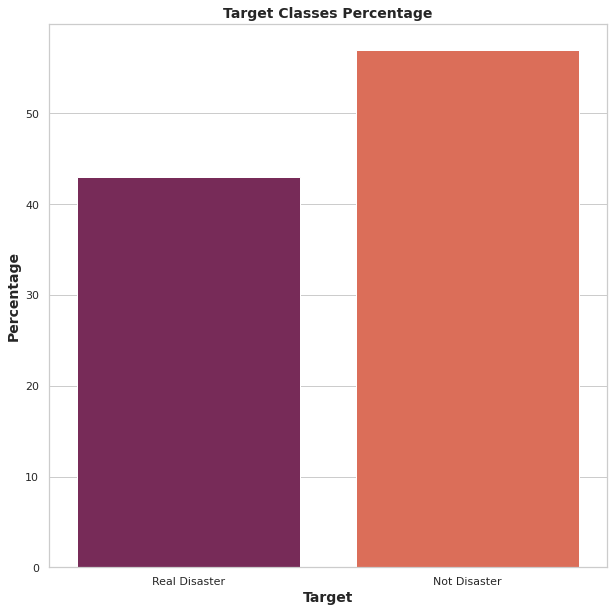

In [7]:
labels = ['Real Disaster', 'Not Disaster']
amount = []
amount.append(train.loc[train.target == 1].shape[0]/train.shape[0]*100)
amount.append(train.loc[train.target == 0].shape[0]/train.shape[0]*100)
barplot(labels,'Target',amount,'Percentage', 'Target Classes Percentage')

From the figure above we can see that that both classes are well balanced for training. 

# Most Frequent Keywords
The 'keyword' column may give a particular insight about the tweet content. Let's see which of them occur more on the dataset. 

<Figure size 1440x1080 with 0 Axes>

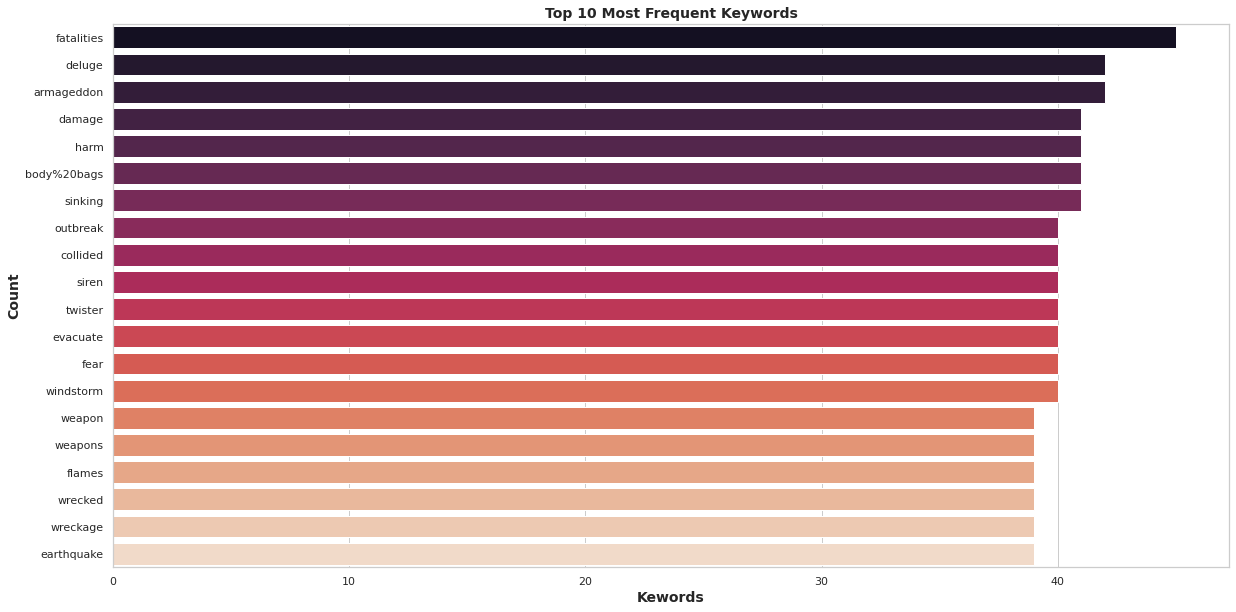

In [8]:
plt.figure(figsize=(20,15))
df = train.keyword.value_counts().to_frame()
barplot(list(df.keyword)[0:20],'Kewords',list(df.index)[0:20],'Count', 'Top 10 Most Frequent Keywords',(20,10))

So, there are a lot of words that semantically seem to be related to disasters, but we have taken the whole column, and not the specific target being equal to one. Let's see how many of these most frequent words are associated to real disasters and how many don't. 

In [9]:
def getDisasterDict(df,train):
    positive = []
    negative = []
    for key in list(df.index[0:20]):
        positive.append(train.loc[(train.keyword == key) & (train.target == 1)].shape[0])
        negative.append(train.loc[(train.keyword == key) & (train.target == 0)].shape[0])
    dict_top10 = {'type': list(df.index[0:20]), 'positives': positive, 'negatives': negative}
    return dict_top10

dict_top10 = getDisasterDict(df,train)

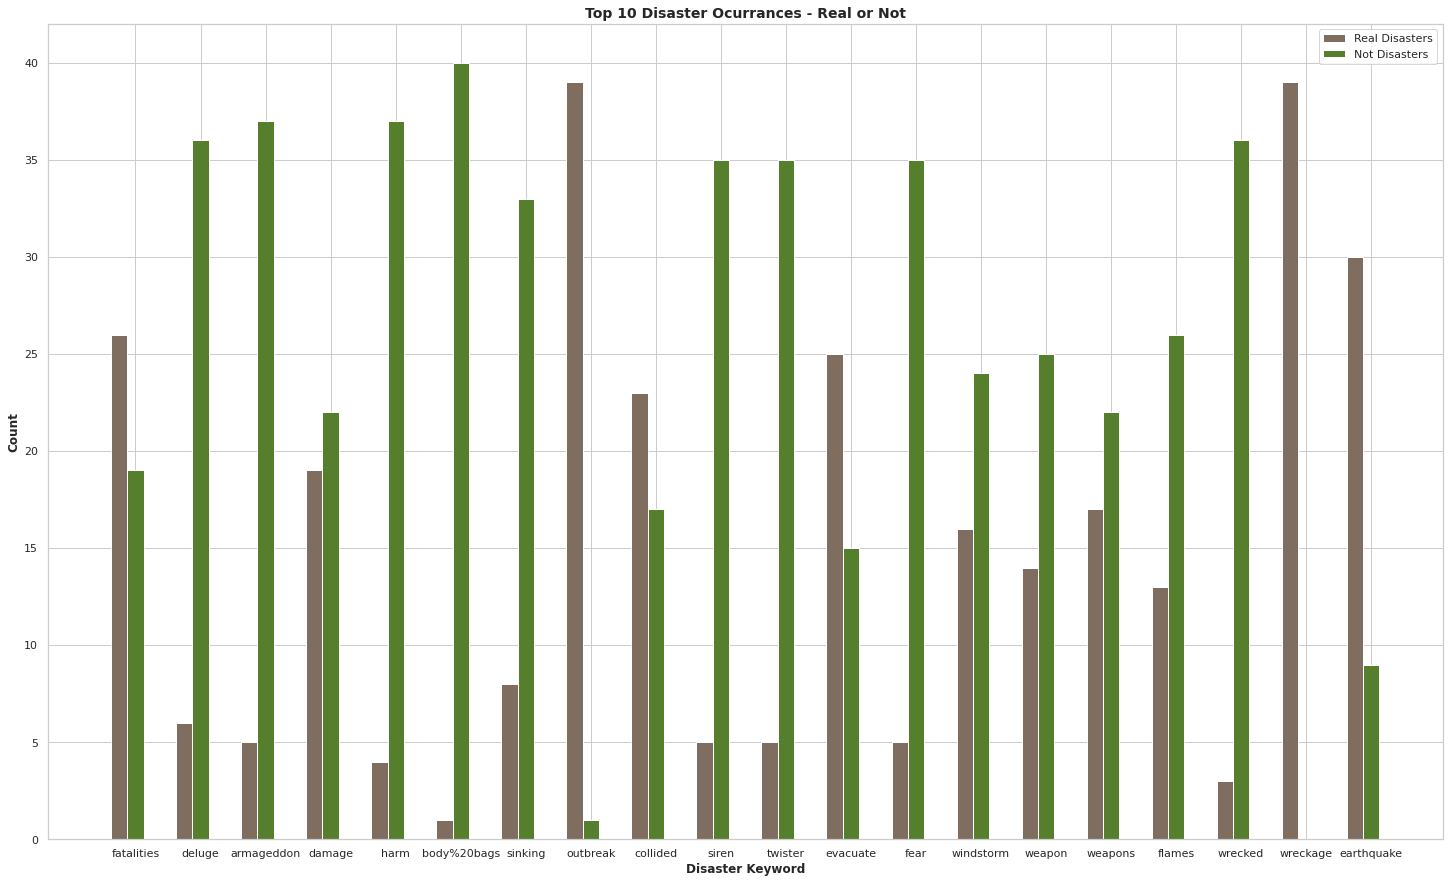

In [10]:
barWidth = 0.25

bars1 = dict_top10['positives']
bars2 = dict_top10['negatives']
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(25,15))
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Real Disasters')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Not Disasters')
 
plt.title("Top 10 Disaster Ocurrances - Real or Not", fontsize=14, fontweight='bold')
plt.xlabel('Disaster Keyword', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], list(dict_top10['type']))
 
plt.legend()
plt.show()

As evidenced above, although some words seem to be attached to real disasters, in most cases they are not. Some of them, such as 'fatalities', 'collided', 'outbreak', 'evacuate', 'collision and 'famine' tend to occur more in real disaster examples. For further feature engineering we should pay attention to them, since they might to help to classify the tweet. 

### Analyzing Features
A probability distribution is a function that describes the likelihood of obtaining the possible values that a random variable can assume. So it might give some insights about the behavior of some features. 

### Number of Characters in a Tweet
Let's analyze if there are significant differences between train and test distribution plots for both classes. 

In [11]:
def getNumberWords (row):
    return len(row.text.split())

def getNumberUnique(row):
    return len(set(str(row).split()))

def getMeanLength(row):
    words = row.split()
    return sum(len(word) for word in words) / len(words)

from nltk.corpus import stopwords    
stop_words = set(stopwords.words('english'))
train['stopwords'] = train['text'].str.split().apply(lambda x: len(set(x) & stop_words))
train.head()

,id,keyword,location,text,target,stopwords
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,5
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,7
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,5


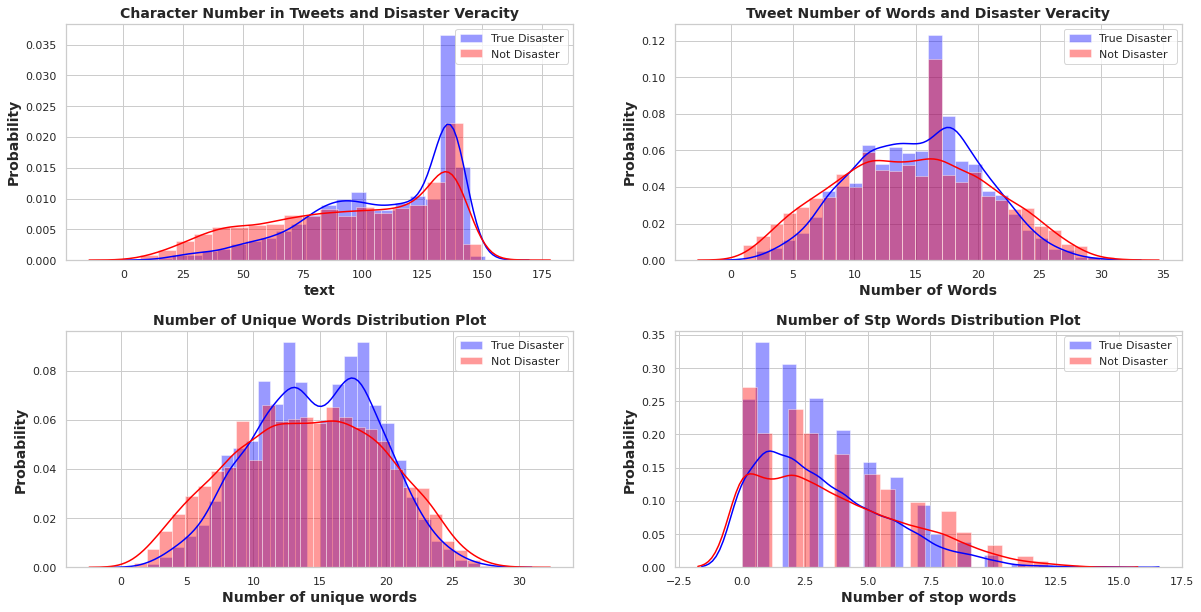

In [12]:
f, axes = plt.subplots(2, 2,figsize=(20,10))
true_disaster = train[train.target == 1]['text'].str.len()
false_disaster = train[train.target == 0]['text'].str.len()
#plt.figure(figsize=(20,10))
#"Character Number in Tweets and Disaster Veracity"
axes[0][0].set_title("Character Number in Tweets and Disaster Veracity",fontsize=14,fontweight='bold')
axes[0][0].set_xlabel('Tweet Length',fontsize=14, fontweight='bold')
axes[0][0].set_ylabel('Probability',fontsize=14, fontweight='bold')
sns.distplot( true_disaster , color="blue", label='True Disaster',ax=axes[0][0])
sns.distplot( false_disaster , color="red", label="Not Disaster",ax=axes[0][0])
axes[0][0].legend()

train['number_words_real'] = train[train.target == 1].apply(lambda row: getNumberWords(row), axis=1)
train['number_words_fake'] = train[train.target == 0].apply(lambda row: getNumberWords(row), axis=1)

axes[0][1].set_title("Tweet Number of Words and Disaster Veracity", fontsize=14,fontweight='bold')
axes[0][1].set_xlabel('Number of Words',fontsize=14,fontweight='bold')
axes[0][1].set_ylabel('Probability', fontsize=14,fontweight='bold')
sns.distplot( list(train['number_words_real']) , color="blue", label='True Disaster',ax=axes[0][1])
sns.distplot( list(train['number_words_fake']) , color="red", label="Not Disaster",ax=axes[0][1])
axes[0][1].legend()


train['unique_words'] = train.text.apply(lambda row: getNumberUnique(row))

axes[1][0].set_title("Number of Unique Words Distribution Plot", fontsize=14,fontweight='bold')
axes[1][0].set_xlabel('Number of unique words', fontsize=14,fontweight='bold')
axes[1][0].set_ylabel('Probability', fontsize=14,fontweight='bold')
sns.distplot( list(train[train.target == 1].unique_words) , color="blue", label='True Disaster',ax=axes[1][0])
sns.distplot( list(train[train.target == 0].unique_words) , color="red", label="Not Disaster",ax=axes[1][0])
axes[1][0].legend()


axes[1][1].set_title("Number of Stp Words Distribution Plot", fontsize=14,fontweight='bold')
axes[1][1].set_xlabel('Number of stop words', fontsize=14,fontweight='bold')
axes[1][1].set_ylabel('Probability', fontsize=14,fontweight='bold')
sns.distplot( list(train[train.target == 1].stopwords) , color="blue", label='True Disaster',ax=axes[1][1])
sns.distplot( list(train[train.target == 0].stopwords) , color="red", label="Not Disaster",ax=axes[1][1])
axes[1][1].legend()
f.subplots_adjust(hspace=0.3)
plt.show()

From these plots we might infer:
* The most probable number of characters in a tweet is aroung 135 for both classes (disasters and not disasters). They are very similar and might not provide our model with relevant information
* The number of words that happen the most is 17 for real disasters. The distribution of not disasters is close to that, but there are some differences on the curves that might help the model to distingish the classes
* The number of unique words distribution plots seems to show more differences between the classes. Whilst the not disaster distribution plot looks like a normal distribution shape, the true disaster curve has a different shape. Due to these differences, this feature could be selected in the future to help the model making decisions. 


### Number of Hashtags and At Sign

We might find that the use of hashtags and at signs could help to distinguish the classes. Let's feature engineer them and analyze the results. 

In [13]:
import re
def elementCount(row,string):
    if string == '#':
        return len(re.findall(r"#(\w+)", row))
    else:
        return len(re.findall(r"@(\w+)", row))

train['hashtag_count'] = train.text.apply(lambda row: elementCount(row,'#'))
train['at_count'] = train.text.apply(lambda row: elementCount(row,'@'))

In [14]:
train.describe()

,id,target,stopwords,number_words_real,number_words_fake,unique_words,hashtag_count,at_count
count,7613.000000,7613.00000,7613.000000,3271.000000,4342.000000,7613.000000,7613.000000,7613.000000
mean,5441.934848,0.42966,3.405097,15.167533,14.704744,14.340733,0.437410,0.356627
std,3137.116090,0.49506,2.785149,5.096806,6.161564,5.277160,1.085629,0.714569
min,1.000000,0.00000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000
25%,2734.000000,0.00000,1.000000,11.000000,10.000000,11.000000,0.000000,0.000000
50%,5408.000000,0.00000,3.000000,15.000000,15.000000,14.000000,0.000000,0.000000
75%,8146.000000,1.00000,5.000000,19.000000,19.000000,18.000000,0.000000,1.000000
max,10873.000000,1.00000,15.000000,30.000000,31.000000,29.000000,13.000000,8.000000


As one can see, the number of hashtags and at signs on average are less than one, with a high standard deviation value. Let's analyze if

In [15]:
train[train.target == 1].hashtag_count

0       1
1       0
2       0
3       1
4       2
       ..
7608    0
7609    0
7610    0
7611    0
7612    0
Name: hashtag_count, Length: 3271, dtype: int64

In [16]:
print("Correlation between target and hashtag_count ", train.target.corr(train.hashtag_count))
print("Correlation between target and at_count ", train.target.corr(train.at_count))

Correlation between target and hashtag_count  0.05163254635810441
Correlation between target and at_count  -0.10269173062066972


From these correlation results, it seems that the counting variables in respect to hashtags and at signs are not relevant to the problem. 

### Most Frequent Hashtags

In [17]:
hashtags_real_disasters = []
hashtags_fake_disasters = []
for row in range(train.shape[0]):
    if row < train[train.target == 1].shape[0]:
        hashtags_real_disasters.extend(re.findall(r"#(\w+)", train[train.target == 1].reset_index().text[row]))
    if row < train[train.target == 0].shape[0]:
        hashtags_fake_disasters.extend(re.findall(r"#(\w+)", train[train.target == 0].reset_index().text[row]))
        
hashtags_real_disasters = [x.lower() for x in hashtags_real_disasters]
hashtags_fake_disasters = [x.lower() for x in hashtags_fake_disasters]

hashtags_real_disasters = dict(Counter(hashtags_real_disasters))
hashtags_real_disasters = dict(sorted(hashtags_real_disasters.items(), key=operator.itemgetter(1),reverse=True))
hashtags_fake_disasters = dict(Counter(hashtags_fake_disasters))
hashtags_fake_disasters = dict(sorted(hashtags_fake_disasters.items(), key=operator.itemgetter(1),reverse=True))


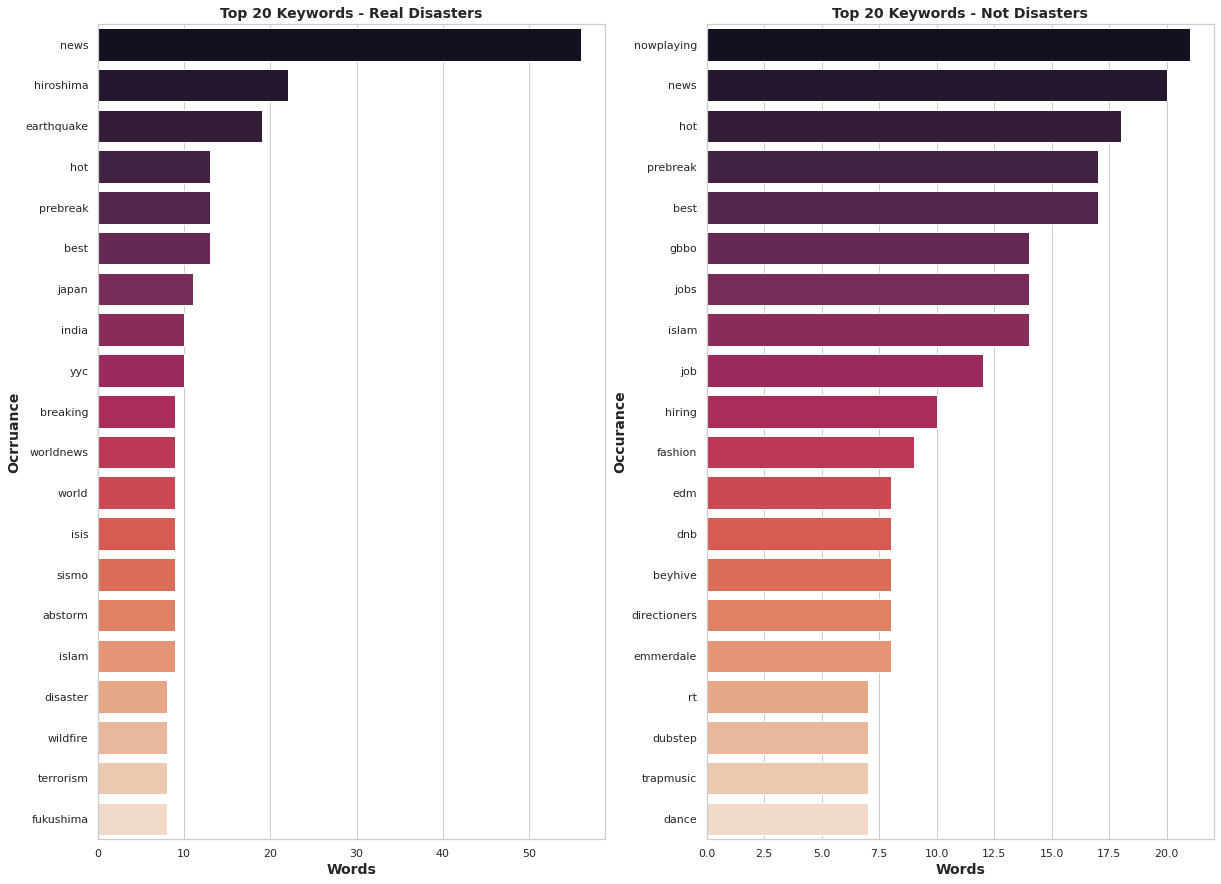

In [18]:
f, axes = plt.subplots(1, 2,figsize=(20,15))
sns.set(style="whitegrid")
axes[0].set_title('Top 20 Keywords - Real Disasters',fontsize=14,fontweight="bold")
axes[0].set_xlabel('Words',fontsize=14,fontweight="bold")
axes[0].set_ylabel('Ocrruance',fontsize=14,fontweight="bold")
sns.barplot(list(hashtags_real_disasters.values())[0:20], list(hashtags_real_disasters.keys())[0:20],ax=axes[0],palette='rocket')

axes[1].set_title('Top 20 Keywords - Not Disasters',fontsize=14,fontweight="bold")
axes[1].set_xlabel('Words',fontsize=14,fontweight="bold")
axes[1].set_ylabel('Occurance',fontsize=14,fontweight="bold")
sns.barplot(list(hashtags_fake_disasters.values())[0:20], list(hashtags_fake_disasters.keys())[0:20],ax=axes[1],palette='rocket')

plt.show()



As we can see, there are some frequent words that could denote real and not real disasters, such as 'earthquake', 'hiroshima' and others. However, there are some of them present on both labels, such as 'news', 'hot', 'best' that don't help to make good decisions about the label. These should be removed from the dataset. Furthermore, some of these keywords could be used as features to the model. 

# Data Cleaning
Before we move on exploring the text, we need to remove/convert:
1. Convert all strings to lower case.
2. Remove URLs and HTMLs
3. Remove emojis
4. Remove symbols (this includes # and @)
5. Remove stopwords 
6. Correct mispelling
7. Convert slangs and contractions (thanks to [Up-to-date list of Slangs for Text Preprocessing](https://www.kaggle.com/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing) and  [NLP with Disaster Tweets - EDA, Cleaning and BERT](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert) for providing a list of them)

In [19]:
def contractions(tweet):
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
    
    return tweet

In [20]:


def removeNonEnglish(row):
    words = set(nltk.corpus.words.words())
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
             if w.lower() in words or not w.isalpha())

def convertToLowerCase(row):
    return row.lower()

def removeNumbers(row):
    return re.sub('[0-9]+', '', row)

def removeURL(row):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',row)

def removeHTML(row):
    html=re.compile(r'<.*?>')
    return html.sub(r'',row)

def removeEmoji(row):
    return row.encode('ascii', 'ignore').decode('ascii')

def removeSymbols(row):
    return re.sub(r'[^\w]', ' ', row)

def removeUnderscore(row):
    return row.replace("_","")

def removeStopWords(row):
    filtered_sentence = []
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(row) 
    return ' '.join([word for word in word_tokens if word not in stop_words])

def removeSpecialChar(row):
    punctuations = '@#!_?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        row = row.replace(p, f' {p} ')
    return row


abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "yr" : 'year',
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev(row):
    return abbreviations[row.lower()] if row.lower() in abbreviations.keys() else row



Apllying all of these cleaning functions to both train and test sets:

In [21]:

def cleanAll(train):
    train['text'] = train.text.apply(lambda row: convertToLowerCase(row))
    train['text'] = train.text.apply(lambda row: contractions(row))
    train['text'] = train.text.apply(lambda row: convert_abbrev(row))
    train['text'] = train.text.apply(lambda row: removeURL(row))
    train['text'] = train.text.apply(lambda row: removeNumbers(row))
    train['text'] = train.text.apply(lambda row: removeSymbols(row))
    train['text'] = train.text.apply(lambda row: removeHTML(row))
    train['text'] = train.text.apply(lambda row: removeEmoji(row))
    train['text'] = train.text.apply(lambda row: convertToLowerCase(row))
    train['text'] = train.text.apply(lambda row: removeUnderscore(row))
    train['text'] = train.text.apply(lambda row: removeStopWords(row))
    train['text'] = train.text.apply(lambda row: removeSpecialChar(row))
    #train['text'] = train.text.apply(lambda row: removeNonEnglish(row))
    return train

train = cleanAll(train)
test = cleanAll(test)

### Top Words - After Cleaning

In [22]:
from collections import Counter
from collections import OrderedDict
from operator import itemgetter    

real_disasters = list(train[train.target == 1].text.str.cat(sep=' ').lower().split())
not_disasters = list(train[train.target == 0].text.str.cat(sep=' ').lower().split())
counts_real = dict(Counter(real_disasters))
counts_not_real= dict(Counter(not_disasters))
real_disasters_occurance = dict(OrderedDict(sorted(counts_real.items(), key = itemgetter(1), reverse = True)))
not_disasters_occurance = dict(OrderedDict(sorted(counts_not_real.items(), key = itemgetter(1), reverse = True)))

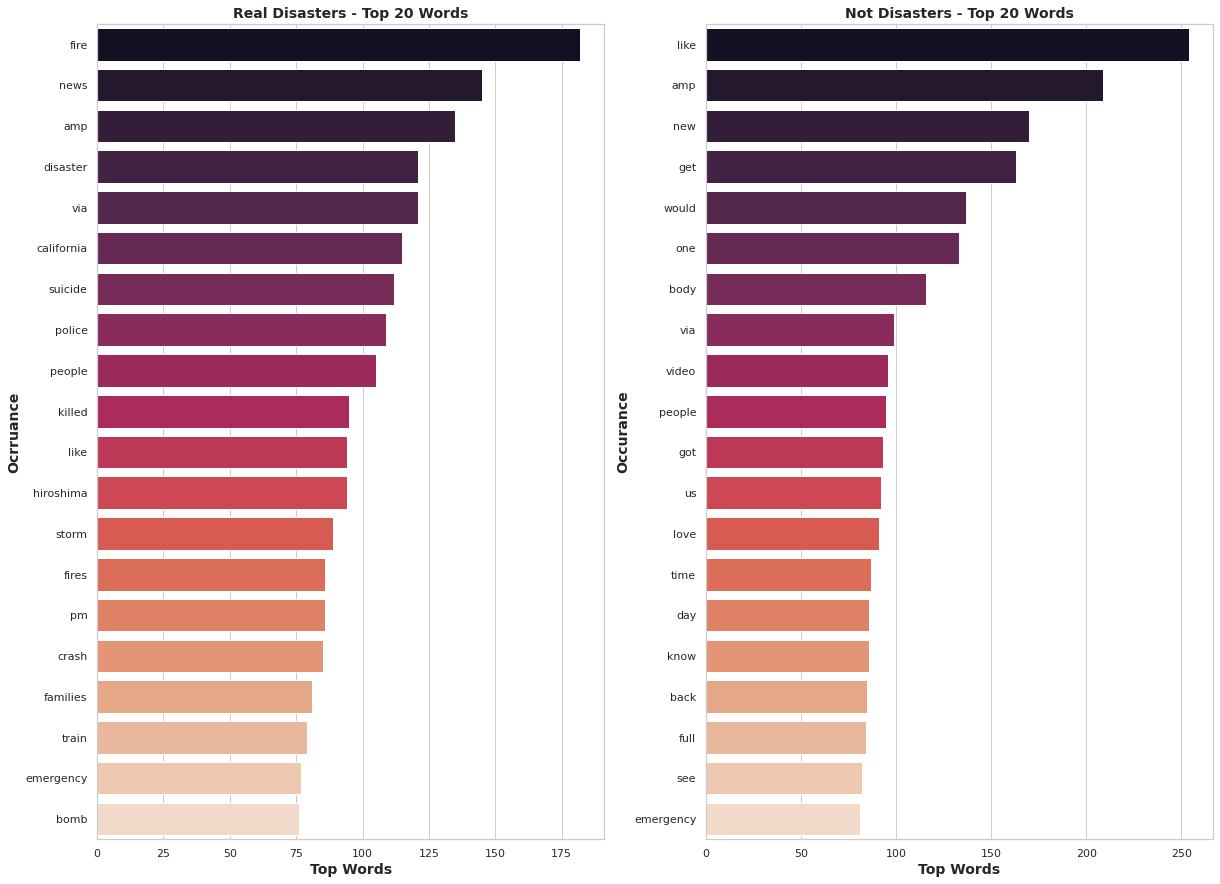

In [23]:
f, axes = plt.subplots(1, 2,figsize=(20,15))
sns.set(style="whitegrid")
axes[0].set_title('Real Disasters - Top 20 Words',fontsize=14,fontweight="bold")
axes[0].set_xlabel('Top Words',fontsize=14,fontweight="bold")
axes[0].set_ylabel('Ocrruance',fontsize=14,fontweight="bold")
sns.barplot(list(real_disasters_occurance.values())[0:20], list(real_disasters_occurance.keys())[0:20],ax=axes[0],palette='rocket')

axes[1].set_title('Not Disasters - Top 20 Words',fontsize=14,fontweight="bold")
axes[1].set_xlabel('Top Words',fontsize=14,fontweight="bold")
axes[1].set_ylabel('Occurance',fontsize=14,fontweight="bold")
sns.barplot(list(not_disasters_occurance.values())[0:20], list(not_disasters_occurance.keys())[0:20],ax=axes[1],palette='rocket')

plt.show()


### Word Clouds
Word Clouds are a visual representation of the frequency importance of each word on some text. We are going to build a sorted dictionary with the most frequent words for both classes (disasters and not disasters) and visualize their word clouds.


In [24]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def generateWordCloud(df):
    text =df
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'white',
        stopwords = STOPWORDS).generate(str(text))
    fig = plt.figure(
        figsize = (10, 6),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

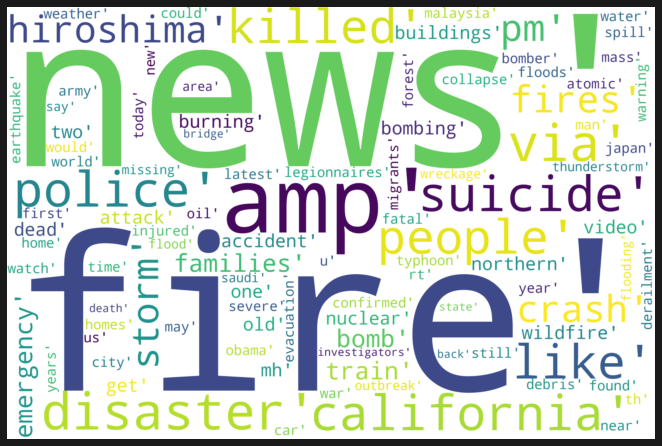

In [25]:
generateWordCloud(list(real_disasters_occurance.keys())[0:100])

#### Not Disasters

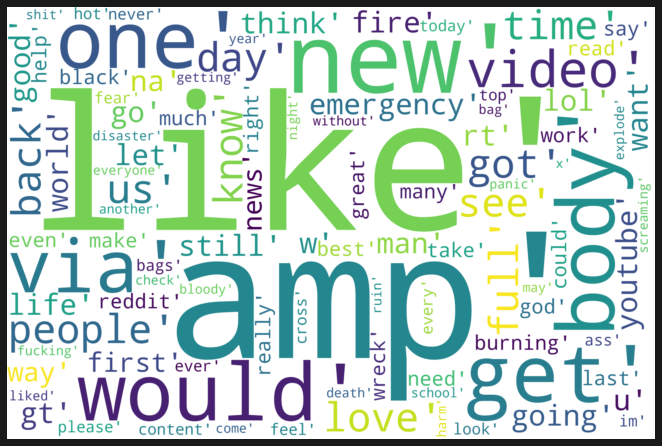

In [26]:
generateWordCloud(list(not_disasters_occurance.keys())[0:100])

As we can see, the stop words and irrelevant characters and phrases were remove from the dataset. There are some frequent words that occur in both cases, such as amp, like, people, etc. These should be removed from the dataset, since they could muddle the model. 

### N-Grams

"In the fields of computational linguistics and probability, an n-gram is a contiguous sequence of n items from a given sample of text or speech."(Wikipedia). So they could be useful to understand the most important combination of words on a text and thus help to understand how ideas were structured.

#### Most Frequent Bigrams

In [27]:
def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))

def convertTuple(tup): 
    str =  ' '.join(tup) 
    return str

train['bigrams'] = train['text'].map(lambda x: find_ngrams(x.split(" "), 2))
bigrams_real = train[train.target == 1].bigrams.tolist()
bigrams_real = list(chain(*bigrams_real))
bigrams_real = [(x.lower(), y.lower()) for x,y in bigrams_real]

bigrams_fake = train[train.target == 0].bigrams.tolist()
bigrams_fake = list(chain(*bigrams_fake))
bigrams_fake = [(x.lower(), y.lower()) for x,y in bigrams_fake]

bigram_counts_real = Counter(bigrams_real)
bigram_real_dict = dict(bigram_counts_real.most_common(20))

bigram_counts_fake = Counter(bigrams_fake)
bigram_fake_dict = dict(bigram_counts_fake.most_common(20))

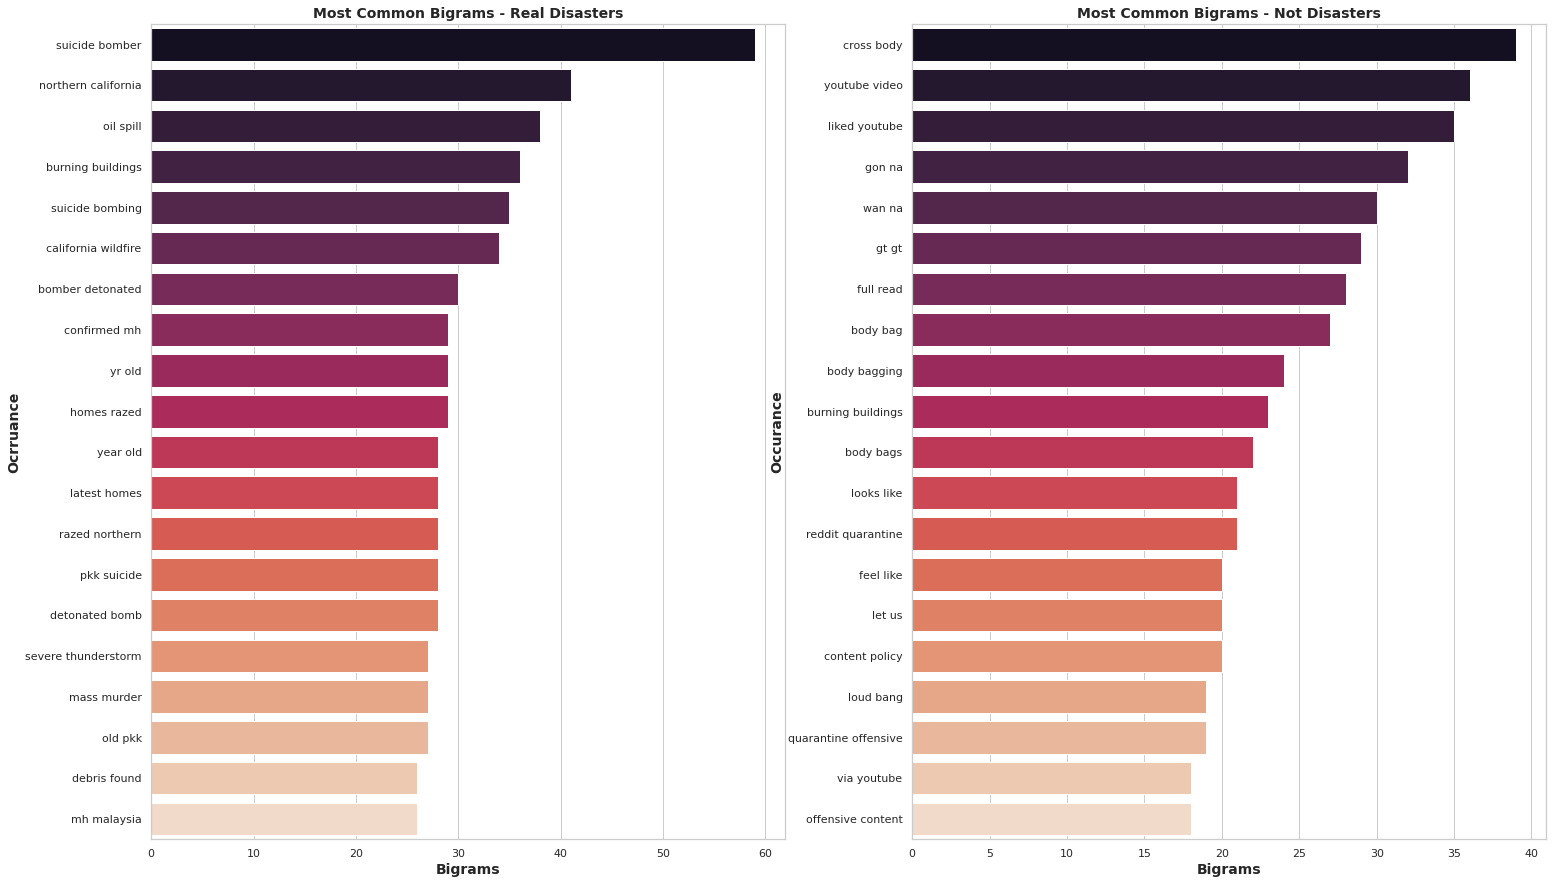

In [28]:
bigrams_real = []
bigrams_fake = []
for bigram in range(len(bigram_real_dict)):
    bigrams_real.append(convertTuple(list(bigram_real_dict.keys())[bigram]))
    bigrams_fake.append(convertTuple(list(bigram_fake_dict.keys())[bigram]))


f, axes = plt.subplots(1, 2,figsize=(25,15))
sns.set(style="whitegrid")
axes[0].set_title('Most Common Bigrams - Real Disasters',fontsize=14,fontweight="bold")
axes[0].set_xlabel('Bigrams',fontsize=14,fontweight="bold")
axes[0].set_ylabel('Ocrruance',fontsize=14,fontweight="bold")
sns.barplot(list(bigram_real_dict.values()),bigrams_real,ax=axes[0],palette='rocket')

axes[1].set_title('Most Common Bigrams - Not Disasters',fontsize=14,fontweight="bold")
axes[1].set_xlabel('Bigrams',fontsize=14,fontweight="bold")
axes[1].set_ylabel('Occurance',fontsize=14,fontweight="bold")
sns.barplot(list(bigram_fake_dict.values()),bigrams_fake,ax=axes[1],palette='rocket')

plt.show()    


Now we have much more relevant context from each label, rather than just isolated words, especially for disaster labeled texts. For not disaster tweets we can see that the semantics seem to be related to other topics explicitilly not related to disasters. 

#### Most Frequent Trigrams

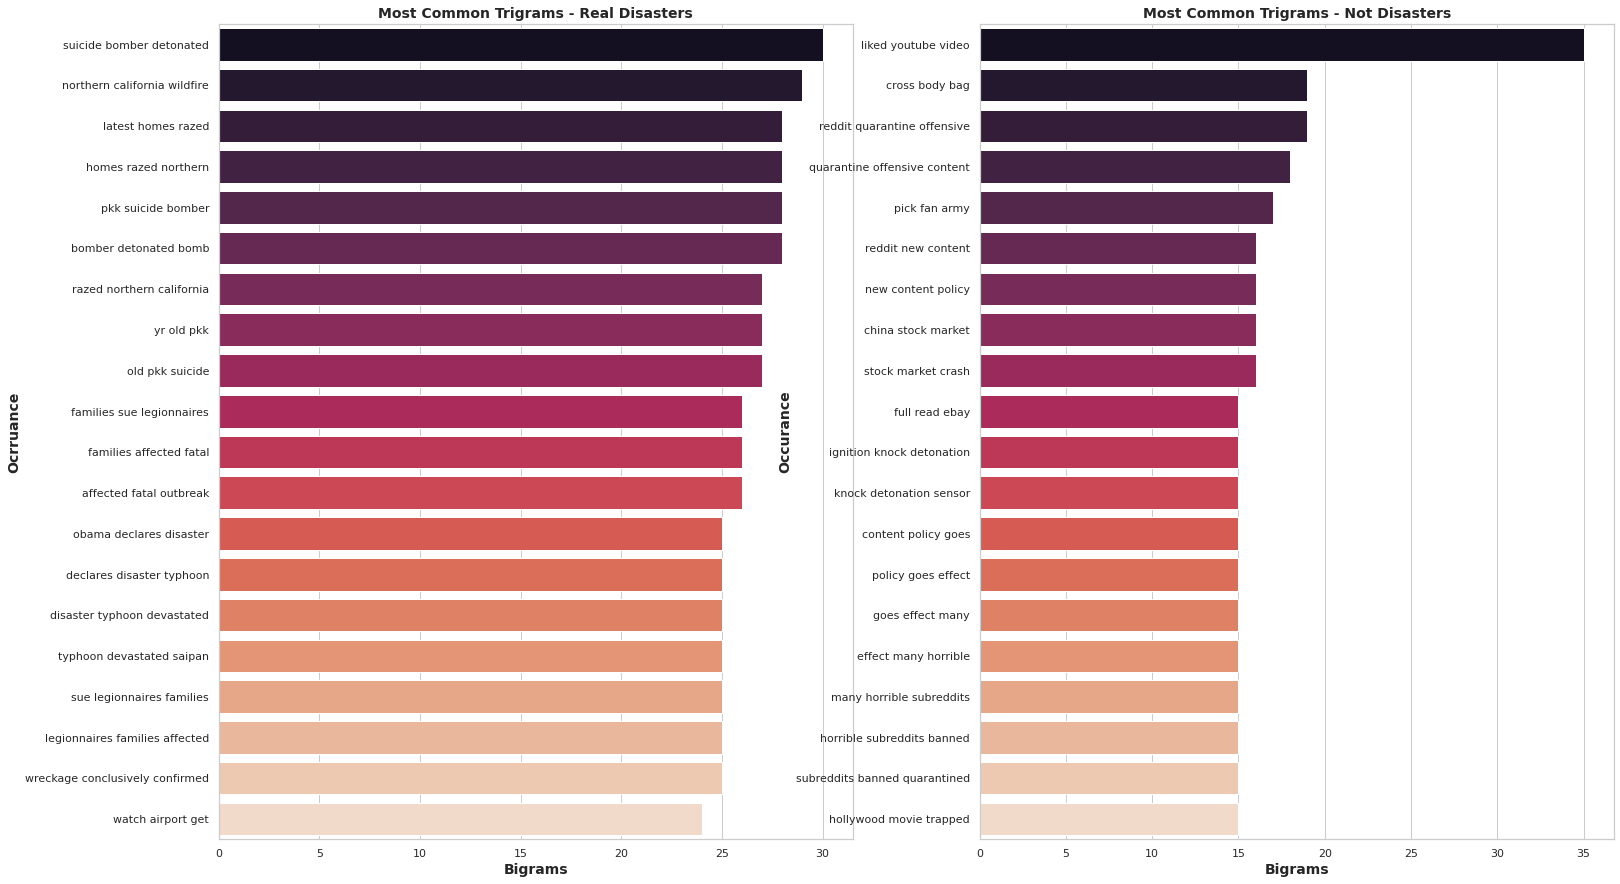

In [29]:
def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))

def convertTuple(tup): 
    str =  ' '.join(tup) 
    return str

train['trigrams'] = train['text'].map(lambda x: find_ngrams(x.split(" "), 3))
trigrams_real = train[train.target == 1].trigrams.tolist()
trigrams_real = list(chain(*trigrams_real))
trigrams_real = [(x.lower(), y.lower(), z.lower()) for x,y,z in trigrams_real]

trigrams_fake = train[train.target == 0].trigrams.tolist()
trigrams_fake = list(chain(*trigrams_fake))
trigrams_fake = [(x.lower(), y.lower(), z.lower()) for x,y,z in trigrams_fake]

trigram_counts_real = Counter(trigrams_real)
trigram_real_dict = dict(trigram_counts_real.most_common(20))

trigram_counts_fake = Counter(trigrams_fake)
trigram_fake_dict = dict(trigram_counts_fake.most_common(20))

trigrams_real = []
trigrams_fake = []
for bigram in range(len(bigram_real_dict)):
    trigrams_real.append(convertTuple(list(trigram_real_dict.keys())[bigram]))
    trigrams_fake.append(convertTuple(list(trigram_fake_dict.keys())[bigram]))


f, axes = plt.subplots(1, 2,figsize=(25,15))
sns.set(style="whitegrid")
axes[0].set_title('Most Common Trigrams - Real Disasters',fontsize=14,fontweight="bold")
axes[0].set_xlabel('Bigrams',fontsize=14,fontweight="bold")
axes[0].set_ylabel('Ocrruance',fontsize=14,fontweight="bold")
sns.barplot(list(trigram_real_dict.values()),trigrams_real,ax=axes[0],palette='rocket')

axes[1].set_title('Most Common Trigrams - Not Disasters',fontsize=14,fontweight="bold")
axes[1].set_xlabel('Bigrams',fontsize=14,fontweight="bold")
axes[1].set_ylabel('Occurance',fontsize=14,fontweight="bold")
sns.barplot(list(trigram_fake_dict.values()),trigrams_fake,ax=axes[1],palette='rocket')

plt.show()    

# Lemmatization
Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item. One exemple can be seen below:

<img src="https://searchingforbole.files.wordpress.com/2018/01/re-learning-english-multiple1.png?w=624">


To achieve that, we are going to use nltk package at each tweet. 

In [30]:
from nltk.stem import WordNetLemmatizer     
lemmatizer = WordNetLemmatizer()
#lemmatizer.lemmatize()

def getLemma(row):
    text = row
    text = text.lower().split(" ")
    lemma = [lemmatizer.lemmatize(each) for each in text]
    return lemma

train['text'] = train.text.apply(lambda row: getLemma(row))
train.head()

,id,keyword,location,text,target,stopwords,number_words_real,number_words_fake,unique_words,hashtag_count,at_count,bigrams,trigrams
0,1,NaN,NaN,"[deed, reason, earthquake, may, allah, forgive...",1,5,13.0,NaN,13,1,0,"[(deeds, reason), (reason, earthquake), (earth...","[(deeds, reason, earthquake), (reason, earthqu..."
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1,0,7.0,NaN,7,0,0,"[(forest, fire), (fire, near), (near, la), (la...","[(forest, fire, near), (fire, near, la), (near..."
2,5,NaN,NaN,"[resident, asked, shelter, place, notified, of...",1,7,22.0,NaN,20,0,0,"[(residents, asked), (asked, shelter), (shelte...","[(residents, asked, shelter), (asked, shelter,..."
3,6,NaN,NaN,"[people, receive, wildfire, evacuation, order,...",1,1,8.0,NaN,8,1,0,"[(people, receive), (receive, wildfires), (wil...","[(people, receive, wildfires), (receive, wildf..."
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1,5,16.0,NaN,15,2,0,"[(got, sent), (sent, photo), (photo, ruby), (r...","[(got, sent, photo), (sent, photo, ruby), (pho..."


In [31]:
train['text'] = train.text.apply(lambda row: " ".join(row))

# Word Embeddings
A word embedding is a learned representation for text where words that have the same meaning have a similar representation. So, if we can apply this representation to our dataset, theoretically we can provide to our model a much more significant data. 

### Glove vs Embedding Layer



Embeddings are methods for learning vector representations of one-hot-encoded categorical data. GloVe it's one of these techniques, and it is based on matrix factorization techniques on the word-context matrix. It first constructs a large matrix of co-occurrence information, basically counting how frequently we see one word in some “context” in a large corpus. What embeddings do, is they simply learn to map the one-hot encoded categorical variables to vectors of floating point numbers of smaller dimensionality then the input vectors. <br>

The Keras Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset. It can be trained from scratch, or you can use pre-trained models, such as Glove, and use transfer-learning, and this can be advantageosu, since the pretrained embeddings were trained on large volumes of text.

We are going to test training the embedding layer jointly with the whole model and by using transfer learning and the loaded wheigts from Glove. 

### Data Tokenization

Here we call a function to tokenize the data. To save time, we apply the tokenization to train and test data merged, and after that we return the separated sets. 

In [32]:
def tokenize(train,test):
    
    train_ = train.text
    test_ = test.text
    full = train_.append(test_)
    tokenizer = Tokenizer() 
    tokenizer.fit_on_texts(full)
    sequences = tokenizer.texts_to_sequences(full)

    word_index = tokenizer.word_index
    both_datasets = pad_sequences(sequences)
    train_data = both_datasets[:len(train)]
    test_data = both_datasets[len(train):]
    labels = train['target']

    return train_data, labels, word_index, test_data



X_train, y_train, word_index, X_test = tokenize(train,test)

X_test.shape

(3263, 25)

From the glove model we are going to use the file related to the 200-dimensional version of the embedding.

In [33]:
embeddings_index = {}
with open('../input/glove-data/glove.6B.200d.txt') as f:
    for line in (f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()
embedding_dim = 200
print('Found %s word vectors in the GloVe library' % len(embeddings_index))

Found 400000 word vectors in the GloVe library


We now search for the words that we are going to use during training and form a matrix of weights related to those words. 

In [34]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


### Baseline Model

Now we define an initial model to address the problem. The layers are: 

* Embedding: transforms the input data to a space of 200 dimensions, with a vocabulary related to the number of words that occur on our training set. The input_length parameter is set as 31, which is the value of the mean number of words on the dataset plus the std.
* GlobalAveragePooling: gives a sparse representation of the Embedding layer output. Minimizes overfitting by reducing the total number of parameters in the model and extracts features from the input.
* Dense: consists in a linear operation between the weights, in which all the inputs are connected to the ouput. The aim is to take the inputs from the feature analysis and apply weights to classify the initial input. The last one takes the operations between the previous layer activations multiplied by the weights and, by activating that signal with a sigmoid, converts it into a probability of belonging to a binary class.

In [35]:

embedding_dim = 200
max_length = 31
trunc_type='post'

train_sentences = train.text.tolist()
train_labels = train.target
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences,maxlen=max_length, truncating=trunc_type)



model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(len(word_index)+1, embedding_dim, input_length=max_length))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(14, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='Nadam',metrics=['accuracy'])
model.summary()
num_epochs = 10
history = model.fit(train_padded, train_labels, epochs=num_epochs,validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 200)           2978000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 14)                2814      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 2,980,829
Trainable params: 2,980,829
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
191/191 [==============================] - 5s 25ms/step - loss: 0.6670 - accuracy: 0.5872 - val_loss: 0.6510 - val_accuracy: 0.5863
Epoch 2/10
191/191 [==============================] - 4s 23ms/step - loss: 0.5346 - accuracy: 0.7703 

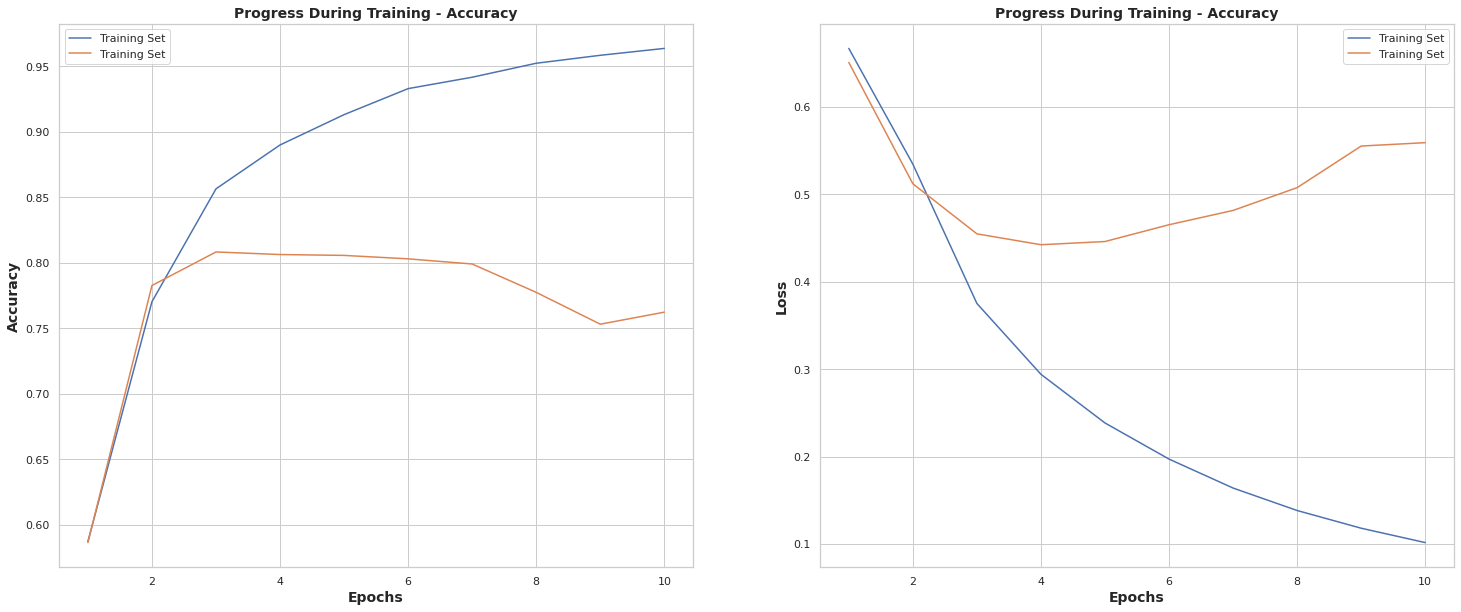

In [36]:
f, axes = plt.subplots(1, 2,figsize=(25,10))
axes[0].set_title('Progress During Training - Accuracy',fontweight='bold',fontsize=14)
axes[0].set_xlabel('Epochs',fontweight='bold',fontsize=14)
axes[0].set_ylabel('Accuracy',fontweight='bold',fontsize=14)
axes[0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'],label='Training Set')
axes[0].plot(range(1,len(history.history['accuracy'])+1),history.history['val_accuracy'],label='Training Set')
axes[0].legend()

axes[1].set_title('Progress During Training - Accuracy',fontweight='bold',fontsize=14)
axes[1].set_xlabel('Epochs',fontweight='bold',fontsize=14)
axes[1].set_ylabel('Loss',fontweight='bold',fontsize=14)
axes[1].plot(range(1,len(history.history['accuracy'])+1),history.history['loss'],label='Training Set')
axes[1].plot(range(1,len(history.history['accuracy'])+1),history.history['val_loss'],label='Training Set')
axes[1].legend()
plt.show()

As infered from these plots, the model seems to overfit considerably. Loss value seems to be stuck and so the accuracy, which seems not to improve even for more epochs of training (tending to drop).

### More Elaborated Model 
Now we are using Transfer Learning. The weights loaded previously from the Glove model are used on the Embedding layer, and this layer is not trained (trainable = False). We also experimentally added a dropout layer to prevent overfitting. The LSTM model was tested, but the results were not good as the baseline upgraded model. Further discussion include proposing LSTM as an alternative. 

In [37]:
train_size = (0.1*X_train.shape[0])
x_train = X_train[:int(train_size)]
y_train_ = y_train[:int(train_size)]
x_validation = X_train[int(train_size):]
y_validation = y_train[int(train_size):]
x_validation.shape

(6852, 25)

We have chosen Nadam as the optmizer due to its good performance on multiple previous tests. Since it is a binary classification problem, we have set the loss function as binary crossentropy.

In [38]:
def create_model():

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(19633, 200, weights=[embedding_matrix], input_length=31,trainable=False))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(14, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'Nadam', metrics = ['accuracy'])
    return model

def LSTM():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(len(word_index)+1, 200, weights=[embedding_matrix], input_length=31,trainable=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, dropout=0.2, recurrent_dropout=0.2)))
    model.add(tf.keras.layers.Dense(14, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'Nadam', metrics = ['accuracy'])
    return model

In [39]:
model2 = create_model()
model2.summary()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history2 = model2.fit(X_train, y_train, validation_data=(x_validation,y_validation),
         epochs = 30, batch_size = 32, verbose = 1, shuffle = True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 200)           3926600   
_________________________________________________________________
dropout (Dropout)            (None, 31, 200)           0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                2814      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 15        
Total params: 3,929,429
Trainable params: 2,829
Non-trainable params: 3,926,600
_________________________________________________________________
Epoch 1/30
238/238 [==============================] - 1s 5ms/step - loss: 0.5709 - accuracy: 0.7406 - val_

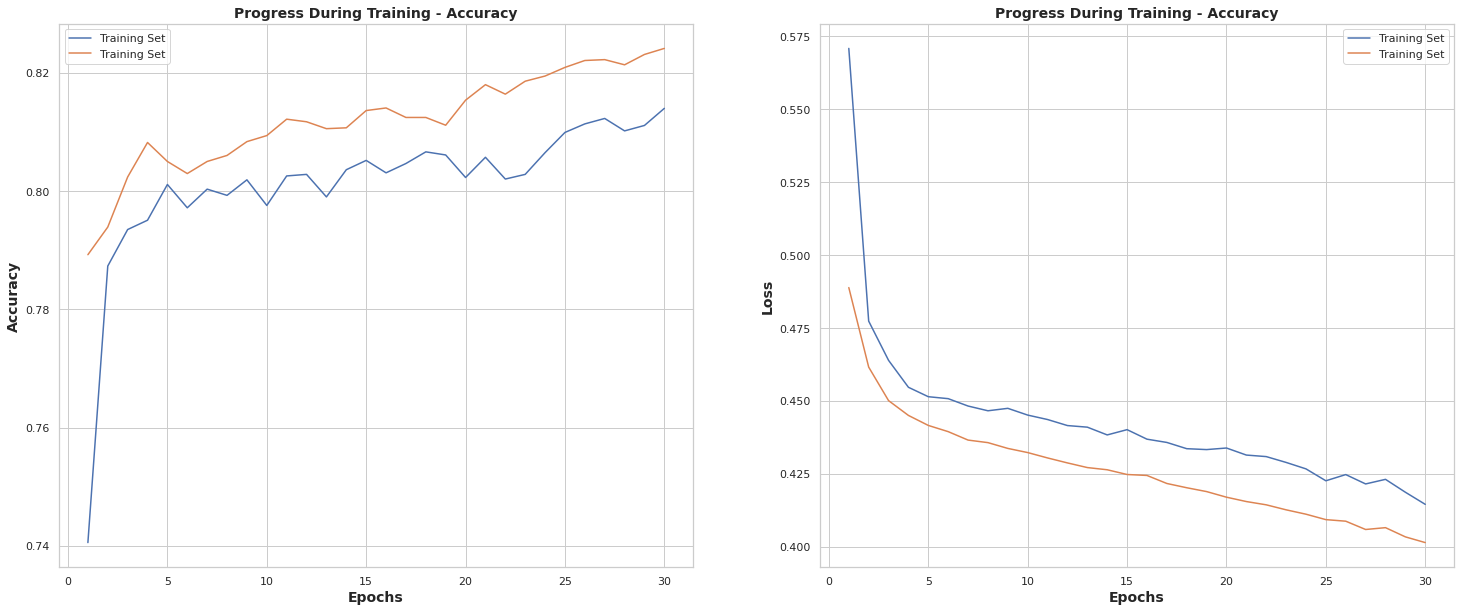

In [40]:
f, axes = plt.subplots(1, 2,figsize=(25,10))
axes[0].set_title('Progress During Training - Accuracy',fontweight='bold',fontsize=14)
axes[0].set_xlabel('Epochs',fontweight='bold',fontsize=14)
axes[0].set_ylabel('Accuracy',fontweight='bold',fontsize=14)
axes[0].plot(range(1,len(history2.history['accuracy'])+1),history2.history['accuracy'],label='Training Set')
axes[0].plot(range(1,len(history2.history['accuracy'])+1),history2.history['val_accuracy'],label='Training Set')
axes[0].legend()

axes[1].set_title('Progress During Training - Accuracy',fontweight='bold',fontsize=14)
axes[1].set_xlabel('Epochs',fontweight='bold',fontsize=14)
axes[1].set_ylabel('Loss',fontweight='bold',fontsize=14)
axes[1].plot(range(1,len(history2.history['accuracy'])+1),history2.history['loss'],label='Training Set')
axes[1].plot(range(1,len(history2.history['accuracy'])+1),history2.history['val_loss'],label='Training Set')
axes[1].legend()
plt.show()

From the plots above, the model  seems much more stable. Overfitting was reduced, and there might be a trending of improvement if the model is trained for more epochs. However, it seems to be stuck around 82% of accuracy on the test set. 

### Evaluating The Model - Confusion Matrix

Thanks to [Plot a Confusion Matrix](https://www.kaggle.com/grfiv4/plot-a-confusion-matrix) for the excellent function provided.

In [41]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontweight='bold',fontsize=14)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontweight='bold',fontsize=14)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass),fontweight='bold',fontsize=14)
    plt.show()
    


### Training and Test Sets

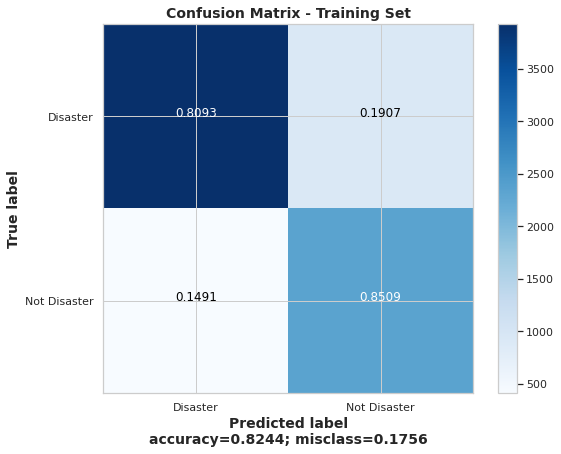

In [42]:
pred = model2.predict(X_train)
Y_pred_classes = np.around(pred.transpose()[0])
Y_true = np.array(y_train)
cm = confusion_matrix(Y_pred_classes,Y_true)     
plot_confusion_matrix(cm,cmap='Blues',normalize=True,target_names=['Disaster','Not Disaster'],title='Confusion Matrix - Training Set')


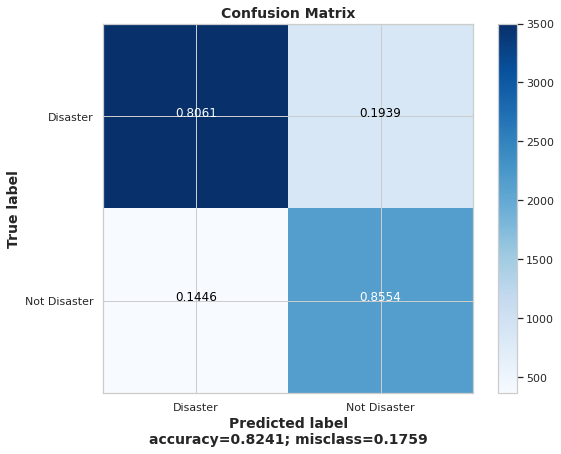

In [43]:
pred = model2.predict(x_validation)
Y_pred_classes = np.around(pred.transpose()[0])
Y_true = np.array(y_validation)
cm = confusion_matrix(Y_pred_classes,Y_true)     
plot_confusion_matrix(cm,normalize=True,target_names=['Disaster','Not Disaster'],title='Confusion Matrix')


As can be seen above, the performance is similar on train and test sets. For both of them, the 'Disaster' class has most of the false positives. So our model is mislabeling around 20% of the real disasters. From the true positives of the 'Not Disaster' class, we can see that our model has a good classification percentage at identifying tweets not related to disasters. The model almost doesn't vary from training at correctly predicting disasters, which is good (shows that overfitting was adressed).

# Submission

In [44]:
test_id = test.id
submission1 = pd.DataFrame()
submission1['id'] = test_id
submission1['target'] = np.around(model2.predict(X_test).transpose()[0]).astype(int)
submission1
submission1.head(10)
submission1.to_csv('submission.csv', index=False)

# Conclusions

The main objective initially proposed was reached. We have come up with hypothesis and some of them showed to be true. We have explored the characteristics of the disaster/not disaster labeld tweets and we have captured some of the trends behind them. We have developed a baseline model that performed quite well on training set, but showed an overfitting behavior on the test set. Using some transfer learning techniques and Glove word embedding, the more elaborated model performed way better. However, some enlightenment/further implementations could be pointed out:
* The second model performed better, especially taking into consideration overfitting, due to previously trained embedding layer and dropout layers that were added. It performed way better because Glove does the word embeddings by aggregating global word-word co-occurrence matrix from a corpus, and it is much more optmized than training an embedding layer from random weights.
* For further enhancements we could propose some comparative testing between lemmatization and stemming techniques. They have different purposes and could lead to different results than what we obtained using just lemmatization. 
* We have analyzed features that were engineered, and some of them, by the distribution plots, seem to be useful to help the model training. They could be concatenated with the X_train matrix and tested to see the possible results. 
* The neural network architecture, after the pre-trained layer, was build from scratch and generic ideas of nlp architectures. Since LSTM and some RNN are very common on NLP context, we could test some of them and analyze the results. We have built one simple LSTM model but there wasn't much of time to test and vary the hyperparameters. 
* Some notebooks point out that some tweets on the training set were mislabeled. Further investigation/correction could be done.
* For feature selection, some of the words presented on the training set could be tested with chi-square hypothesis test to see wether the features (words) one-hot-encoded contribute to the prediction of the labels.


# References 
#### [1] https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e<br>
#### [2] https://labs.bawi.io/deep-learning-word2vec-and-embedding-3b00ff571cc1<br>
#### [3] https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/<br>
#### [4] https://nlp.stanford.edu/projects/glove/<br>
#### [5] https://stats.stackexchange.com/questions/335793/what-is-difference-between-keras-embedding-layer-and-word2vec<br>
#### [6] https://towardsdatascience.com/deep-learning-4-embedding-layers-f9a02d55ac12<br>
#### [7] https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa<br>
#### [8] https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert<br>
#### [9] https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove<br>
#### [10] https://www.pyohio.org/2018/schedule/presentation/38/<br>
#### [11] https://www.youtube.com/watch?v=xvqsFTUsOmc<br>